In [104]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class MPT:
    def __init__(self, relative_ticker, asset_tickers, start_date, period, invest_period):
        self.start_date = start_date
        self.invest_period = invest_period
        self.period = period
        self.asset_tickers = asset_tickers
        self.results = []

        self.asset_data = yf.Tickers(" ".join(self.asset_tickers)).history(period=f"{period}", interval='1d', auto_adjust=False, start=f"{start_date}")

        risk_free_returns = yf.Ticker('^IRX').history(period=f"{period}", interval='1d', auto_adjust=False, start=f"{start_date}")
        self.risk_free_rate = risk_free_returns['Close'].dropna().mean() / 100

        data = yf.Ticker(f"{relative_ticker}").history(period=f"{period}", interval='1d', auto_adjust=False, start=f"{start_date}")
        data.index = data.index.tz_localize(None)
        self.market_returns = data['Adj Close'].pct_change().dropna()

    def expected_return(self, ticker):
        returns = self.asset_data['Adj Close'][ticker].pct_change().dropna()
        beta = returns.cov(self.market_returns) / self.market_returns.var()
        expected_return = self.risk_free_rate + beta * (self.market_returns.mean() * 252 - self.risk_free_rate)
        return expected_return

    def portfolio_volatility(self, weights):
        stddev = 0
        returns_data = self.asset_data['Adj Close'].pct_change().dropna()       
        for i in range(len(weights)):
            for j in range(len(weights)):
                stddev += weights[i] * weights[j] * returns_data[self.asset_tickers[i]].cov(returns_data[self.asset_tickers[j]])
        return np.sqrt(stddev * 252)
    
    def mpt(self):
        portfolios = 5000
        individual_returns = [self.expected_return(ticker) for ticker in self.asset_tickers]

        for _ in range(portfolios):
            #randomly get portfolio weights
            weights = np.random.dirichlet(np.ones(len(self.asset_tickers)))
            risk_stddev = self.portfolio_volatility(weights)
            exp_return = np.dot(weights, individual_returns)
            sharpe_ratio = (exp_return - self.risk_free_rate) / risk_stddev
            self.results.append([weights, risk_stddev, exp_return, sharpe_ratio])
    
    def plot_returns(self):
        df = pd.DataFrame(self.results, columns=['weights', 'Risk (StdDev)', 'Expected Return', 'Sharpe Ratio'])
        weights_df = pd.DataFrame(df['weights'].tolist(), columns=[f'Weight_{ticker}' for ticker in self.asset_tickers])
        df_final = pd.concat([weights_df, df.drop(columns=['weights'])], axis=1)
        best_portfolio = df_final.loc[df_final['Sharpe Ratio'].idxmax()]
        
        self.best_portfolio = best_portfolio
        data = yf.Tickers((" ".join(self.asset_tickers))).history(period=f"{self.invest_period}", interval='1d', auto_adjust=False)

        daily_returns = data['Adj Close'].pct_change().dropna()
        weights = np.array([best_portfolio[f"Weight_{ticker}"] for ticker in self.asset_tickers])
        portfolio_daily_returns = daily_returns.dot(weights)
        portfolio_cum_returns = (1 + portfolio_daily_returns).cumprod() - 1
        data = yf.Tickers('^GSPC').history(period=f"{self.invest_period}", interval='1d', auto_adjust=False)
        returns_data_market = data['Adj Close'].pct_change().dropna()   
        returns_data_market = (1 + returns_data_market).cumprod() - 1
        returns_data_market['Portfolio'] = portfolio_cum_returns

        fig, ax = plt.subplots()
        ax.plot(returns_data_market)

        ax.plot(returns_data_market['Portfolio'], label="Tangent Portfolio")
        ax.plot(returns_data_market['^GSPC'], label="S&P 500")
        ax.grid(True)
        ax.set_ylabel('Cummulative Returns')
        ax.set_xlabel("Time")
        ax.legend()

    def efficient_frontier(self):
        risks = [r[1] for r in self.results]
        returns = [r[2] for r in self.results]
        sharpes = [r[3] for r in self.results]

        fig, ax = plt.subplots()

        # Scatter plot colored by Sharpe ratio
        scatter = ax.scatter(risks, returns, c=sharpes, cmap='viridis', alpha=0.6)

        # Add color bar for Sharpe ratio
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Sharpe Ratio')

        # Labels and grid
        ax.set_xlabel('Volatility (Risk)')
        ax.set_ylabel('Expected Return')
        ax.set_title('Portfolio Optimization (MPT)')
        ax.grid(True)
        ax.scatter(self.best_portfolio['Risk (StdDev)'], self.best_portfolio['Expected Return'], marker='x', label='Tangent Portfolio')
        plt.legend()
        plt.show()


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


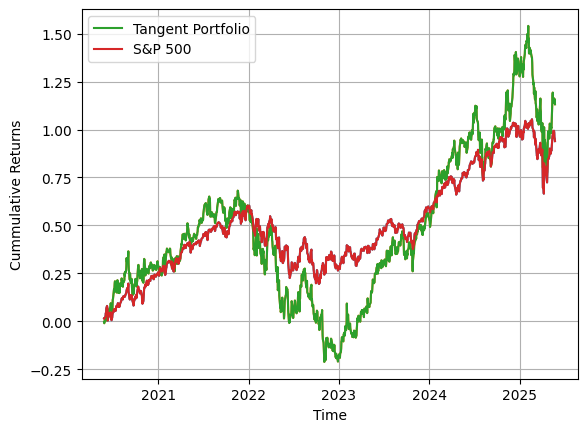

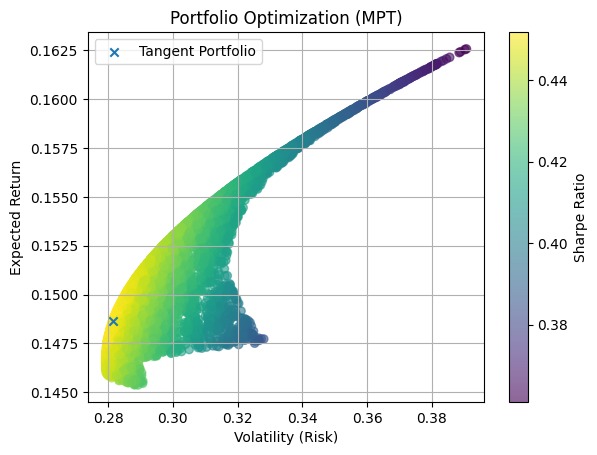

In [ ]:
mpt = MPT('^GSPC', ['GOOGL', 'AMZN', 'META'], '2016-07-18', '5y', '5y')
mpt.mpt()
mpt.plot_returns()
mpt.efficient_frontier()